In [748]:
import pandas as pd
import numpy as np
import networkx as nx
from itertools import combinations
import os
import seaborn as sns
import statistics as stat
from collections import Counter
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from community import community_louvain
import random

In [749]:
def read():
    df = pd.read_csv("../data/analysis/cprr_new_orleans_pd_ipm.csv")
    return df

In [750]:
df = read()
df.shape

(1592, 4)

In [751]:
df

,tracking_id,allegation_uid,uid,agency
0,d1356ddced7c750ae9fd9bd14c783fb1,0100c9d8db4f18b74605ec274bb9054e,3d3927213902a514d5a26598e7d187e2,baton-rouge-pd
1,43c61a17b39d7204c0ab781173d09bb9,e7133a746d397a8632c739c9470265d5,f112f1a632d003cb85cf54870a062e33,baton-rouge-pd
2,43c61a17b39d7204c0ab781173d09bb9,280d116f5cfc2944e76ca755b179fd60,ccaec2cf4522039c49f28de6d2a56237,baton-rouge-pd
3,43c61a17b39d7204c0ab781173d09bb9,4e174a7d1af88e06f8a6f81b1afb29f8,9fe99b15a84be0f3efb2ef5a02bcefcb,baton-rouge-pd
4,43c61a17b39d7204c0ab781173d09bb9,bca21d7d7edf095512e8fe2994e4518a,78272e05dacca625247a0e3e40cd1ec6,baton-rouge-pd
...,...,...,...,...
1587,f63d0e1d8625f89deb7f51c772c92f81,95fba0e0b6c74437b93292f4f6ee2a54,cf18298bd155af4021dd4465f11f67c2,rayne-pd
1588,f63d0e1d8625f89deb7f51c772c92f81,24cee9fdf5c627c4a8bba173ba5283a6,2004e0009f7e68620cc5f55cbe35c6d8,rayne-pd
1589,f63d0e1d8625f89deb7f51c772c92f81,a5d7e783064f5fc20abd19d577dbfa09,5e168f97495eb5021900c9bb71eac3dd,rayne-pd
1590,ab46e7d18efc6f9e02fb0eca160b84df,42211ade146adf06ed1f26f0d8b9116d,9913191ea301550e36df2f3a3c4e4cd5,rayne-pd


In [752]:
# remove outliers 
df = df[~df.tracking_id.isin(df.tracking_id.value_counts().loc[lambda x: x >= 30 ].index)]

In [753]:
d0 = df.groupby('tracking_id').count()
d1 = d0[d0.uid > 1]
group_complaints = list(set(d1.index))


df["count"] = 1
df_perUID = df.drop_duplicates(subset=["tracking_id", "uid"])
df_perUID = df_perUID.pivot_table(index=["tracking_id"], values=["count"], aggfunc="sum").reset_index()
df_perUID = df_perUID.rename(columns={"count": "no_of_officers"})
df_perUID

dict_PerComplaint = dict(zip(df_perUID.tracking_id, df_perUID.no_of_officers))

g = nx.Graph()
for incident in group_complaints:
    numberPer = dict_PerComplaint.get(incident)
    node_pairs = list(combinations(df[df.tracking_id == incident]['uid'].tolist(), 2))
    for node_pair in node_pairs:
        if g.has_edge(node_pair[0], node_pair[1]):
            g[node_pair[0]][node_pair[1]]['weight'] += (1+1/numberPer)
        else:
            g.add_edge(node_pair[0], node_pair[1], weight = (1+1/numberPer))
    if group_complaints.index(incident)%100==0:
        value = str(group_complaints.index(incident)/len(group_complaints)*100)[:5] +  "% complete "
print ("\r ", value, end = " \r "),
print("\r 100.00% complete")

print(nx.info(g))

edgeList = list(g.edges)
toRemove = [nodes for nodes in edgeList if g[nodes[0]][nodes[1]]['weight'] <=2]
g.remove_edges_from(toRemove)
g.remove_nodes_from(list(nx.isolates(g)))

print(nx.info(g))

 100.00% complete  
Graph with 325 nodes and 1042 edges
Graph with 253 nodes and 439 edges


C:\Users\PC\AppData\Local\Temp\ipykernel_16592\579980390.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["count"] = 1
C:\Users\PC\AppData\Local\Temp\ipykernel_16592\579980390.py:28: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(g))
C:\Users\PC\AppData\Local\Temp\ipykernel_16592\579980390.py:35: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(g))


In [754]:
comms = community_louvain.best_partition(g)
random.seed(1)

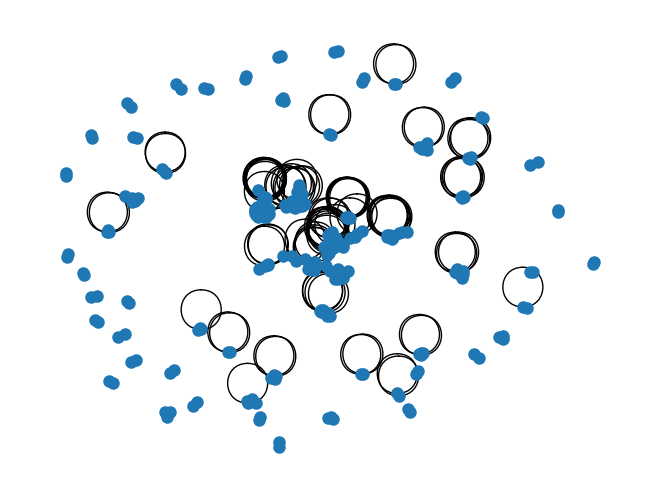

In [755]:
unique_coms = np.unique(list(comms.values()))
unique_coms

pos = nx.spring_layout(g)
nx.draw(g, pos, node_size = 64, alpha = 1)
plt.show()

In [756]:
comm_df = pd.DataFrame.from_dict(comms, orient="index").reset_index()
comm_df = comm_df.rename(columns={comm_df.columns[1]: "community", "index": "uid"})

In [757]:
comm_df

,uid,community
0,67f8aab6360c7505e388bc3aa06eaeef,0
1,c113815f7edb95d166e6dec223958088,0
2,caaeb2ca801f4fd4600764e1599268c3,0
3,637a9f80f424ecfeec0940e40e541b23,0
4,c2162541177e50d835f1f951df52e7ac,2
...,...,...
248,7e7b7ca7cb37bd250555e0b9ad1a0521,19
249,a9db00243c7df7dd419a610fb1e5dee7,19
250,8b958903d72d7ad49c4465cd63b03cfc,19
251,97236c5998424733987b2f43eac22399,19


In [758]:
comm_24 = comm_df[comm_df.community.astype(str).isin(["4"])]
comm_24

,uid,community
9,fb036150c482a9acf676136f7d6a1fd0,4
10,b3bec247905818f3c6e2eb132526f7df,4


In [759]:
review_comms = df[df.tracking_id.isin(["ebf4a9f606deca124f12111f5873b0c5"])]
review_comms

,tracking_id,allegation_uid,uid,agency,count
1250,ebf4a9f606deca124f12111f5873b0c5,dbacebae110de9f6923632fb88171b00,c2162541177e50d835f1f951df52e7ac,new-orleans-pd,1
1251,ebf4a9f606deca124f12111f5873b0c5,c6e0ce7b7f2624b7df1a249c55836d9d,66a62a489db3a1d1ed5ce194543d9a97,new-orleans-pd,1
1252,ebf4a9f606deca124f12111f5873b0c5,2b21c6bcc0ed0939c08dff455c8a2be9,28171586e6d7f52e01faab022a75ff92,new-orleans-pd,1
